# Predicting Next Chords Using a Recurrent Network

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import music21 as m21

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchinfo import summary

from src import chord_parser

In [2]:
parser = chord_parser.Main()

In [3]:
data = pd.read_csv('../Data/data_tokenized_pitch_class.csv')
data["chords"] = data["chords"].apply(lambda x: torch.tensor(json.loads(x)))
data.head()

,url,title,artist,decade,genre,ratings,stars,chords
0,https://tabs.ultimate-guitar.com/tab/jeff-buck...,Hallelujah,Jeff Buckley,1990,Rock|Folk,51639.0,5.0,"[tensor(648), tensor(640), tensor(648), tensor..."
1,https://tabs.ultimate-guitar.com/tab/ed-sheera...,Perfect,Ed Sheeran,2010,Pop,44194.0,5.0,"[tensor(155), tensor(31), tensor(648), tensor(..."
2,https://tabs.ultimate-guitar.com/tab/elvis-pre...,Cant Help Falling In Love,Elvis Presley,1960,"Soundtrack|R&B, Funk & Soul",30059.0,5.0,"[tensor(648), tensor(155), tensor(640), tensor..."
3,https://tabs.ultimate-guitar.com/tab/eagles/ho...,Hotel California,Eagles,1970,Rock,28670.0,5.0,"[tensor(166), tensor(403), tensor(380), tensor..."
4,https://tabs.ultimate-guitar.com/tab/radiohead...,Creep,Radiohead,1990,Rock,28606.0,5.0,"[tensor(155), tensor(78), tensor(648), tensor(..."


In [4]:
augmentation_map = torch.tensor(np.load('../Data/augmentation_map.npy', allow_pickle=True))

with open("../Data/token_to_chord.json", "r") as fp:
    token_to_chord = json.load(fp)

In [5]:
VOCAB_SIZE = len(token_to_chord) + 2 # For start and end of sequence tokens
VOCAB_SIZE

975

## Dataset

In [6]:
class ChordDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def augment(self, chords):
        """Change the root note of the chords by a random amount"""
        move_by = torch.randint(0, 12, [1]).item()
        return augmentation_map[chords, move_by]

    def pad(self, chords):
        """Pad the input tensor [n] into shape [256] with zeros"""
        out = torch.zeros((256))
        out[0] = VOCAB_SIZE - 2 # Start of sequence token
        out[1 : 1 + len(chords)] = chords
        out[1 + len(chords)] = VOCAB_SIZE - 1 # End of sequence token
        return out

    def __getitem__(self, index):
        x = self.data.iloc[index]["chords"]
        x = self.augment(x)
        return self.pad(x).long()

    def __len__(self):
        return len(self.data)

In [7]:
torch.manual_seed(42)

dataset = ChordDataset(data)

train_size = np.rint(len(dataset) * 0.8).astype(int)
train_data, test_data = random_split(dataset, [train_size, len(dataset) - train_size])

In [8]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

## Model

In [9]:
class RecurrentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.chord_embeddings = nn.Embedding(VOCAB_SIZE, 96)
        self.gru = nn.GRU(96, 96, num_layers=3, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, VOCAB_SIZE),
        )
        
    def forward(self, x):
        x = self.chord_embeddings(x)
        x, _ = self.gru(x)
        return self.mlp(x)
    
    def predict_next(self, x):
        x = self.chord_embeddings(x)
        x, _ = self.gru(x)
        return self.mlp(x[:, -1])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RecurrentNet().to(device)

In [11]:
input_tensor = torch.zeros((1, 256), dtype=torch.long, device=device)
summary(model, input_data=input_tensor, device=device)

Layer (type:depth-idx)                   Output Shape              Param #
RecurrentNet                             [1, 256, 975]             --
├─Embedding: 1-1                         [1, 256, 96]              93,600
├─GRU: 1-2                               [1, 256, 96]              167,616
├─Sequential: 1-3                        [1, 256, 975]             --
│    └─Linear: 2-1                       [1, 256, 96]              9,312
│    └─ReLU: 2-2                         [1, 256, 96]              --
│    └─Linear: 2-3                       [1, 256, 975]             94,575
Total params: 365,103
Trainable params: 365,103
Non-trainable params: 0
Total mult-adds (M): 43.11
Input size (MB): 0.00
Forward/backward pass size (MB): 2.59
Params size (MB): 1.46
Estimated Total Size (MB): 4.05

## Trainer

In [12]:
class Trainer():
    def __init__(self, epochs, train_loader, test_loader, model, optimizer, criterion, device, lr_scheduler):
        self.epochs = epochs
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model = model
        self.optimizer = optimizer
        self.one_hot_criterion = criterion
        self.device = device
        self.print_every = 32
        self.lr_scheduler = lr_scheduler
        
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
        self.epoch_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}
    

    def loss_mask(self, y_pred, x):
        """Get the mask for the loss function, so that the loss is not calculated for the padded elements"""
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        mask = range_tensor <= eos_index.unsqueeze(1)
        return mask
    
    def masked_accuracy(self, y_pred, x):
        """Calculate the accuracy of the model only for the elements of the sequence"""
        y_pred, x = y_pred[:, :-1], x[:, 1:]
        eos_index = torch.argmax((x == VOCAB_SIZE - 1).float(), dim=1)
        range_tensor = torch.arange(y_pred.shape[1]).unsqueeze(0).expand(y_pred.shape[0], -1).to(self.device)
        # EOS is not included in the accuracy calculation
        mask = range_tensor < eos_index.unsqueeze(1)
        valid_elements = torch.sum(mask.float())

        same = torch.argmax(y_pred, dim=2) == x
            
        return torch.sum(same.float() * mask.float()) / valid_elements
    
    def masked_cross_entropy(self, logits, target, mask):
        """
        logits: Predictions from the model, of shape (batch_size, sequence_length, vocab_size)
        target: Ground truth labels, of shape (batch_size, sequence_length)
        mask: Binary mask indicating the non-padded parts, of shape (batch_size, sequence_length)
        """

        # Compute the raw CrossEntropyLoss
        loss = nn.CrossEntropyLoss(reduction='none')(logits.transpose(1, 2), target)

        # Apply the mask to the loss
        masked_loss = loss * mask.float()

        # Compute the mean loss over non-padded parts
        final_loss = masked_loss.sum() / mask.float().sum()

        return final_loss
    
    def train_step(self):
        self.model.train()
        for i, x in enumerate(self.train_loader):
            x = x.to(self.device)
            y_pred = self.model(x)
            mask = self.loss_mask(y_pred, x)
            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["train_losses"].append(loss.item())
            
            self.step_data["train_accuracies"].append(self.masked_accuracy(y_pred, x).item())

            if i % self.print_every == self.print_every - 1:
                print(f"Batch {i + 1}/{len(self.train_loader)}, Loss: {loss.item():.4f}, Accuracy: {self.step_data['train_accuracies'][-1]:.4f}")
                            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        self.epoch_data["train_losses"].append(np.array(self.step_data["train_losses"]).mean())
        self.epoch_data["train_accuracies"].append(np.array(self.step_data["train_accuracies"]).mean())
                   
        
    def eval_step(self):
        self.model.eval()
        for i, x in enumerate(self.test_loader):
            x = x.to(self.device)
            with torch.inference_mode():
                y_pred = self.model(x)

            mask = self.loss_mask(y_pred, x)            
            loss = self.masked_cross_entropy(y_pred[:, :-1], x[:, 1:], mask[:, :-1])
            self.step_data["test_losses"].append(loss.item())
                        
            self.step_data["test_accuracies"].append(self.masked_accuracy(y_pred, x).item())
        
        self.epoch_data["test_losses"].append(np.array(self.step_data["test_losses"]).mean())
        self.epoch_data["test_accuracies"].append(np.array(self.step_data["test_accuracies"]).mean())
                    
        
        print(f"Test Loss: {loss.item():.4f}, Accuracy: {self.step_data['test_accuracies'][-1]:.4f}")

    def plot(self):
        fig, axes = plt.subplots(2, 1, figsize=(15, 15))
        axes[0].set_title("Loss")
        sns.lineplot(x=range(len(self.epoch_data["train_losses"])), y=self.epoch_data["train_losses"], label="Train Loss", ax=axes[0])
        sns.lineplot(x=range(len(self.epoch_data["test_losses"])), y=self.epoch_data["test_losses"], label="Test Loss", ax=axes[0])

        axes[1].set_title("Total Accuracy")
        sns.lineplot(x=range(len(self.epoch_data["train_accuracies"])), y=self.epoch_data["train_accuracies"], label="Train Accuracy", ax=axes[1])
        sns.lineplot(x=range(len(self.epoch_data["test_accuracies"])), y=self.epoch_data["test_accuracies"], label="Test Accuracy", ax=axes[1])
        
    
    def init_metrics(self):
        self.step_data = {"train_losses": [], "test_losses": [], "train_accuracies": [], "test_accuracies": []}

        
    def train(self):    
        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}\n-------------------------------")
            self.init_metrics()
            self.train_step()
            self.eval_step()
            self.lr_scheduler.step()
            
        self.plot()

## Training

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.3)
trainer = Trainer(
    epochs=50,
    train_loader=train_loader,
    test_loader=test_loader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    lr_scheduler=lr_scheduler,
)

Epoch 1/50
-------------------------------
Batch 32/139, Loss: 3.9620, Accuracy: 0.0564
Batch 64/139, Loss: 3.5954, Accuracy: 0.1500
Batch 96/139, Loss: 3.0728, Accuracy: 0.1946
Batch 128/139, Loss: 2.9088, Accuracy: 0.1803
Test Loss: 2.8494, Accuracy: 0.2040
Epoch 2/50
-------------------------------
Batch 32/139, Loss: 2.7284, Accuracy: 0.1938
Batch 64/139, Loss: 2.6917, Accuracy: 0.2037
Batch 96/139, Loss: 2.7800, Accuracy: 0.2024
Batch 128/139, Loss: 2.5491, Accuracy: 0.2290
Test Loss: 2.4726, Accuracy: 0.2413
Epoch 3/50
-------------------------------
Batch 32/139, Loss: 2.5242, Accuracy: 0.2779
Batch 64/139, Loss: 2.4094, Accuracy: 0.3061
Batch 96/139, Loss: 2.3232, Accuracy: 0.3296
Batch 128/139, Loss: 2.3697, Accuracy: 0.3438
Test Loss: 2.3450, Accuracy: 0.3779
Epoch 4/50
-------------------------------
Batch 32/139, Loss: 2.2502, Accuracy: 0.3992
Batch 64/139, Loss: 2.3877, Accuracy: 0.3776
Batch 96/139, Loss: 2.2846, Accuracy: 0.4185
Batch 128/139, Loss: 2.0586, Accuracy: 0.4

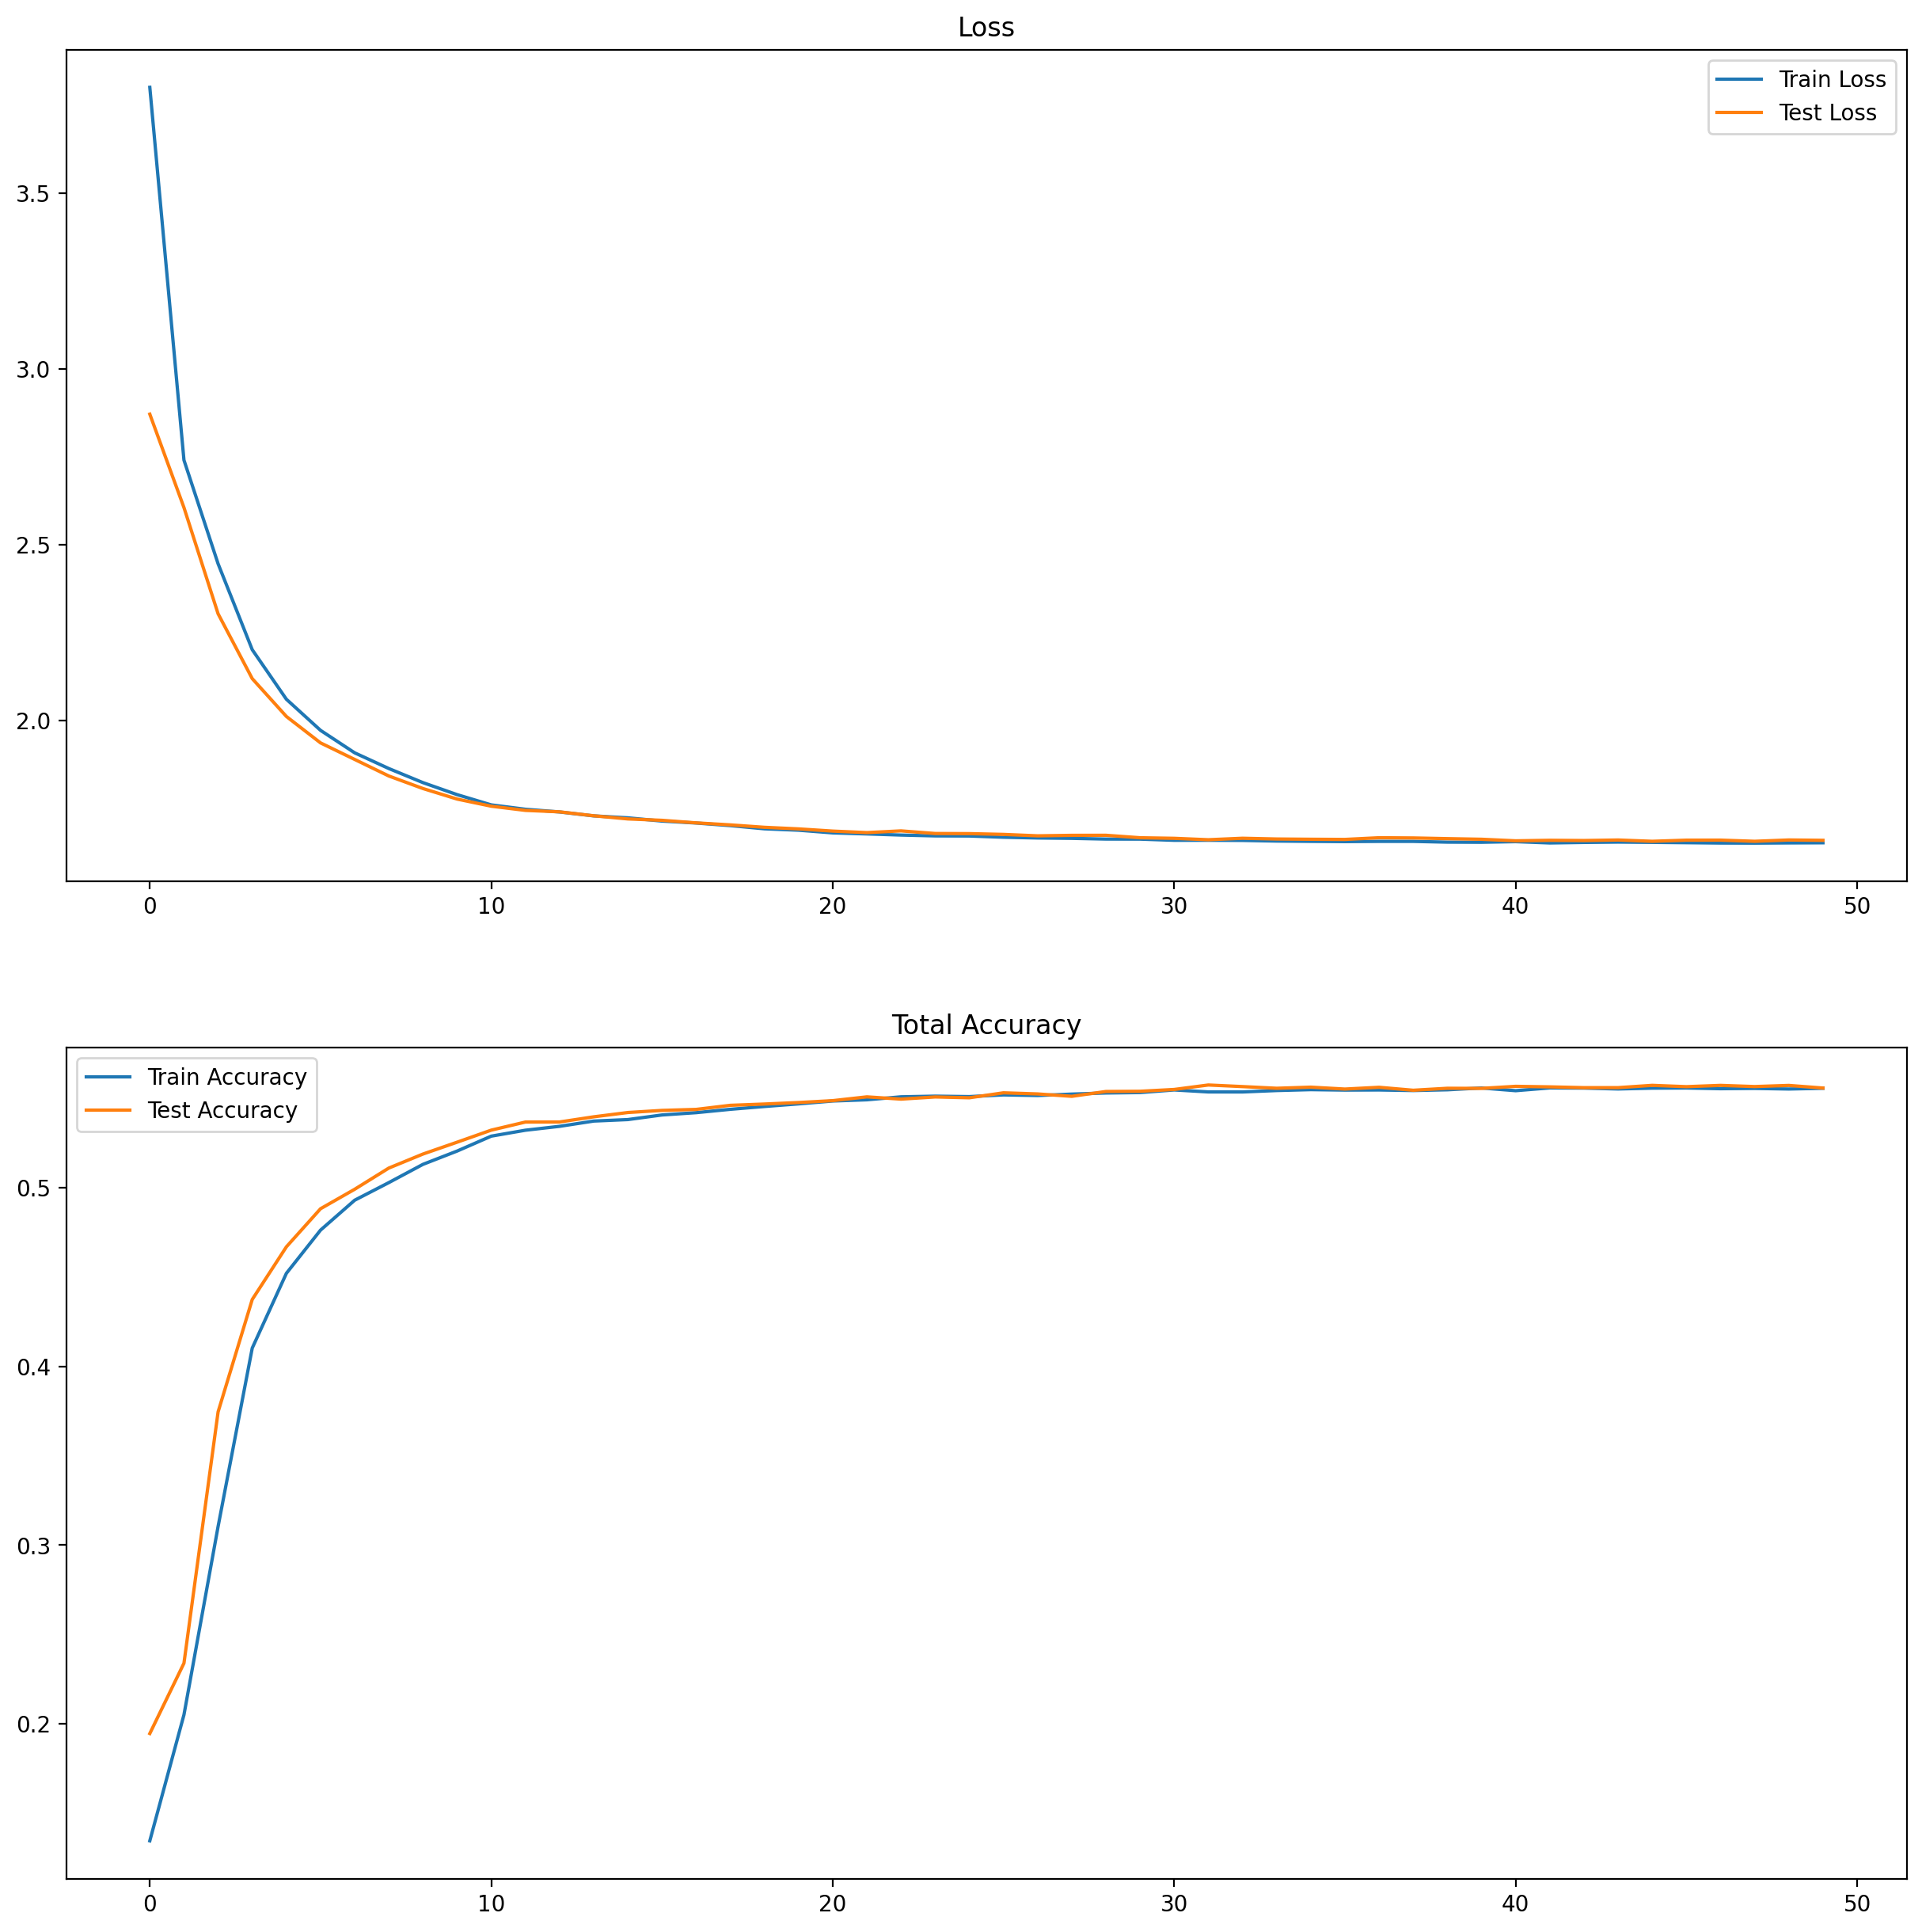

In [14]:
trainer.train()

In [15]:
torch.save(model.state_dict(), "../Models/RecurrentNet.pt")

## Inference

In [16]:
from src import seq_interpreter

interpreter = seq_interpreter.Main(parser)

In [17]:
def generate_sequence(temperature, max_length):
    model.eval()
    with torch.inference_mode():
        x = torch.zeros((1, max_length + 2), dtype=torch.long, device=device)
        # The start of sequence token
        x[:, 0] = VOCAB_SIZE - 2
        
        for i in range(max_length):
            y_pred = model(x[:, : i + 1])
            y_pred = y_pred[:, i]
            # Zero out the probability for the same as the previous chord
            y_pred[:, x[:, i]] = -torch.inf
            # Sample from the distribution
            y_pred = F.softmax(y_pred, dim=1) ** (1 / temperature)
            x[:, i + 1] = y_pred.multinomial(1).item()
            if x[:, i + 1] == VOCAB_SIZE - 1:
                break
        if VOCAB_SIZE - 1 not in x:
            x[:, -1] = VOCAB_SIZE - 1
    return x[0, 1:]

In [18]:
seq = generate_sequence(1.0, 254)
print(interpreter.token_seq_to_chords(seq))
interpreter.play_seq(seq)

F# | B | F# | F#m | B | F# | C# | B | F# | D#m | B7 | F# | B | F# | C#7 | F# | B | F# | C#7 | F# | B | F# | F#7 | B | F# | G#7 | F# | B | F# | B | F# | C#7 | B | F# | B | F# | B | F# | B | F# | B | F# | G#7 | C# | B | F# | C#7 | F# | B | F# | B | F#
